# [Computational Social Science] Project 4: Unsupervised Learning

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

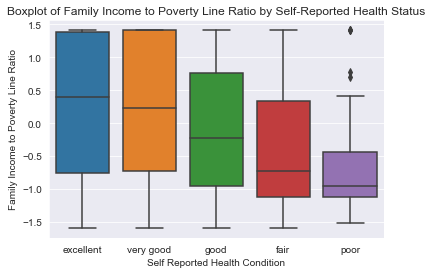

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

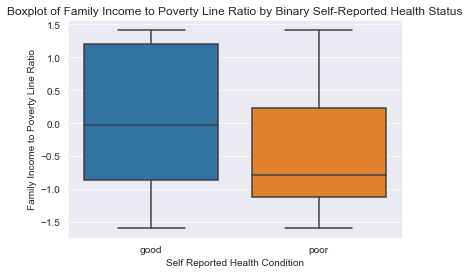

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

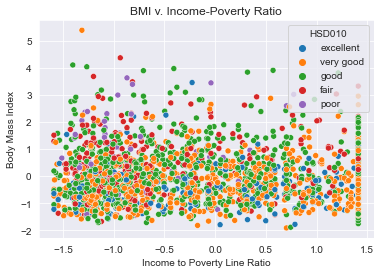

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

We chose 0.90 as a parameter to the PCA model, indicating that PCA will retain 90% of the variance and the minimum number of principal components needed to capture 90% variance will be used. In this case, 90% of the variance amounts to 120 principal components. Although there isn't a "perfect" formula to calculate the ideal variance principal components should explain, we chose 90% in alignment with the field which suggests 90-95% as one standard practice.

In [7]:
# Check out first 5 rows
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


In [8]:
from sklearn.decomposition import PCA
pca = PCA(0.90)
principalcomponents_nhanes = pca.fit_transform(nhanes_scaled)
pca.n_components_

120

In [9]:
#PCA on 120 components of NHANES dataset to have 90% of variance explained
from sklearn.decomposition import PCA
pca = PCA(n_components=120)
principalcomponents_nhanes = pca.fit_transform(nhanes_scaled)

In [10]:
#Explained variation per component
print(pca.explained_variance_ratio_)

[0.10201961 0.07623011 0.04371192 0.02882172 0.02357132 0.0190163
 0.01810852 0.01655592 0.01557116 0.01532197 0.01319964 0.01212789
 0.01157937 0.01155981 0.01110006 0.01004583 0.00943223 0.00932323
 0.00880415 0.00869019 0.00840107 0.00826031 0.00796175 0.00782771
 0.00753776 0.00723654 0.00711077 0.0069405  0.00679366 0.00645714
 0.00639643 0.0063175  0.00621793 0.00617769 0.00592802 0.00577448
 0.00568501 0.00562987 0.00561665 0.0055556  0.00549452 0.00543061
 0.00531559 0.0052795  0.00521778 0.00516137 0.00510838 0.00501916
 0.00498497 0.00495458 0.00491099 0.00484255 0.00482116 0.00474975
 0.00472127 0.00463745 0.00462388 0.00458755 0.00451126 0.00448825
 0.00447018 0.00438592 0.00437359 0.00433289 0.00428992 0.00425922
 0.0042354  0.00420439 0.00414703 0.0041168  0.00407678 0.00405771
 0.00404045 0.00397632 0.00393708 0.00392604 0.00389837 0.00383535
 0.00379083 0.00377679 0.00373189 0.00370871 0.00368255 0.0036532
 0.00361375 0.00358848 0.00351473 0.00348248 0.00346519 0.003428

In [11]:
#Cumulative variance explained 
np.cumsum(pca.explained_variance_ratio_)

array([0.10201961, 0.17824972, 0.22196164, 0.25078336, 0.27435468,
       0.29337098, 0.3114795 , 0.32803542, 0.34360658, 0.35892855,
       0.37212819, 0.38425608, 0.39583545, 0.40739525, 0.41849532,
       0.42854115, 0.43797337, 0.4472966 , 0.45610075, 0.46479094,
       0.47319201, 0.48145232, 0.48941407, 0.49724178, 0.50477954,
       0.51201608, 0.51912686, 0.52606736, 0.53286101, 0.53931815,
       0.54571458, 0.55203208, 0.55825001, 0.5644277 , 0.57035572,
       0.5761302 , 0.58181521, 0.58744508, 0.59306173, 0.59861733,
       0.60411185, 0.60954246, 0.61485805, 0.62013756, 0.62535533,
       0.63051671, 0.63562509, 0.64064424, 0.64562921, 0.65058379,
       0.65549478, 0.66033734, 0.66515849, 0.66990824, 0.67462951,
       0.67926696, 0.68389084, 0.68847839, 0.69298965, 0.6974779 ,
       0.70194808, 0.706334  , 0.71070759, 0.71504048, 0.7193304 ,
       0.72358962, 0.72782501, 0.7320294 , 0.73617644, 0.74029324,
       0.74437002, 0.74842773, 0.75246817, 0.75644449, 0.76038

### Barplot of Components

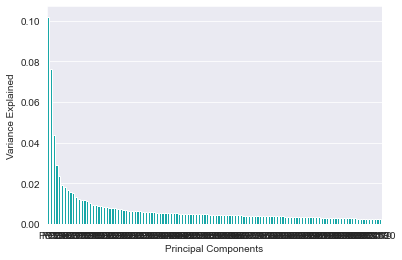

In [12]:
pca_df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                      'PC': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9', 
                             'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15','PC16', 'PC17',
                            'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 
                            'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33',
                            'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39','PC40', 'PC41', 
                             'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47','PC48', 'PC49',
                            'PC50', 'PC51', 'PC52', 'PC53', 'PC54', 'PC55', 'PC56', 'PC57', 
                            'PC58', 'PC59', 'PC60', 'PC61', 'PC62', 'PC63', 'PC64', 'PC65',
                            'PC66', 'PC67', 'PC68', 'PC69', 'PC70', 'PC71', 'PC72', 'PC73', 
                            'PC74', 'PC75', 'PC76', 'PC77', 'PC78', 'PC79', 'PC80', 'PC81',
                            'PC82', 'PC83', 'PC84', 'PC85', 'PC86', 'PC87', 'PC88', 'PC89',
                            'PC90', 'PC91', 'PC92', 'PC93', 'PC94', 'PC95', 'PC96', 'PC97', 
                            'PC98', 'PC99', 'PC100', 'PC101', 'PC102', 'PC103', 'PC104', 'PC105',
                            'PC106', 'PC107', 'PC108', 'PC109', 'PC110', 'PC111', 'PC112', 'PC113', 
                             'PC114', 'PC115', 'PC116', 'PC117', 'PC118','PC119', 'PC120']})
sns.barplot(x='PC', y='var',
           data=pca_df, color="c")
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained');

### How many components will you use to fit a supervised learning model?

After exploring the data, particularly the explained variance per components and the cumulative variance explained, we've decided to only use 16 components to fit a supervised learning model. The first 16 components explain nearly 43% of variability. After component 16, the variance explained by each subsequent component is less than 1%. Therefore, it makes most sense to include the first 16 components to fit the learning model. 

### 2D Scatterplot of the first two components

In [13]:
pc_df = pd.DataFrame(data = principalcomponents_nhanes)
pc_df

plot_df = pd.concat([pc_df, hsd010], axis = 1)

#Recode to make hsd010 binary
plot_df['HSD010_binary'] = hsd010_binary = plot_df['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])
plot_df

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,HSD010,HSD010_binary
0,9.527811,-0.816224,-1.867093,-2.109875,-3.929354,-0.185271,-3.845193,-2.934892,1.514054,0.682536,...,0.652297,-0.528798,0.381753,0.747630,0.026153,0.728968,1.126245,-0.740942,1,good
1,-5.838338,-3.692573,3.805750,-1.029713,0.394510,1.593088,2.710992,-0.740719,0.384955,-2.406350,...,0.114025,1.424296,-0.268761,-1.386157,-0.061795,0.442384,-0.473962,2.195031,1,good
2,-0.719454,-2.573201,0.907904,-4.755881,-1.798875,0.863624,-1.024561,0.633016,0.541990,0.449319,...,-0.136641,-0.415402,0.249158,-0.462062,0.131928,0.395733,-0.546324,-0.033562,2,good
3,3.533627,-2.576982,-3.249120,-0.405406,3.999022,1.444448,-1.182121,0.326427,-4.151050,-1.245472,...,-0.556458,1.266581,-0.957023,-0.498269,0.178790,1.234142,-1.177529,-0.328690,2,good
4,-6.872094,-4.194241,0.886830,-0.848934,-0.524832,0.073095,0.843798,0.987820,0.557080,-0.045099,...,-0.083228,0.011252,-0.357600,-0.684907,-0.577547,0.594103,-0.083164,0.084647,3,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,2.643319,-1.689356,-0.702596,-0.538266,-1.021566,-0.677019,0.473052,-0.288964,0.958712,-1.238135,...,0.388437,-0.609856,-1.135213,-0.084323,-0.681165,0.474137,0.860084,-0.783948,3,good
2060,1.037906,-0.118065,5.556449,1.630054,0.967792,1.146896,1.949495,0.929355,-1.287009,-2.011344,...,-1.313383,0.290374,0.078974,0.430664,-0.458565,0.315968,-0.150370,-0.777306,2,good
2061,1.130253,-0.970432,3.415389,1.206807,-3.631765,1.118475,1.361730,1.827870,-2.339113,0.232431,...,-0.846127,0.549395,-0.062700,1.465102,0.319638,0.041672,0.520882,0.565414,4,poor
2062,7.145093,-0.376752,1.753503,-0.939044,-4.665556,3.844260,-1.355082,2.587527,-0.289933,0.612767,...,-0.434114,-0.350152,-0.496887,-1.326457,-0.044025,0.459268,0.232958,-0.484846,1,good


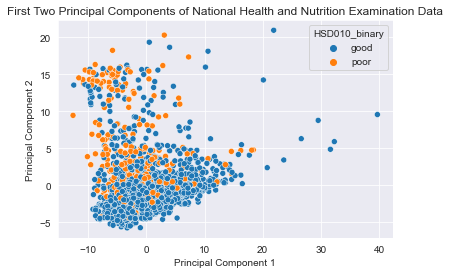

In [14]:
ax = sns.scatterplot(x = plot_df[0], y = plot_df[1], hue = 'HSD010_binary', data = plot_df)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 2")
ax.set_title("First Two Principal Components of National Health and Nutrition Examination Data")
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

**K-Means Clustering:** For our analysis, we have chosen to use K-Means clustering and we will partition data into k-distinct non-overlapping clusters. This technique allows us find subgroups or clusters in data set, however we must first define what will make each group similar and different. Additionally, K-Means clustering requires that we specify the number of clusters (k) so that the algorithm can assign each observation to exactly one of the clusters.  

### Cluster nhanes: Elbow Method
In the elbow method, we conduct k-mean clustering on various values of k and then calculate the sum of squared error for each value of cluster (sum of squared distance from the mean of each cluster), allowing us to identify the optimal value of k. As the values of k increase we expect to see the SSE decrease, and when we plot SSE against the number of clusters we can see an *elbow*--bend in the line--that signals we have optimized k.

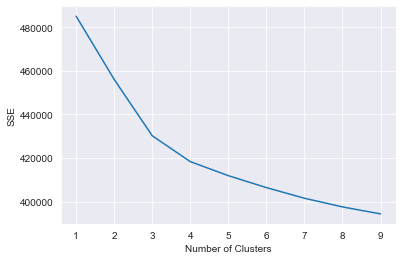

In [15]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(nhanes_scaled)
    nhanes_scaled["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In the above graph, we see an *elbow* at 3 clusters warranting our decision to proceed with k=3 for our K-Mean clustering algorithm. 

In [16]:
np.random.seed(10)

In [17]:
X = nhanes_scaled
kmeans = KMeans(n_clusters=3, max_iter=300).fit(X)
X["Clusters"]=kmeans.labels_

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

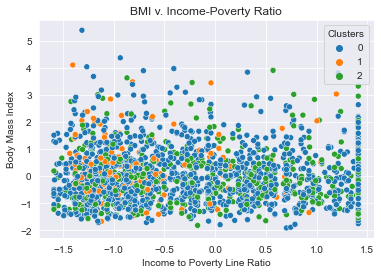

In [18]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "Clusters", palette = "tab10", data = X)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()


When we plot the clusters on top of the BMI v. Income-Poverty Ratio graph, it is difficult to discern any patterns in the data, which suggests that there is not a relationship between the clusters and these two features.  

### Retraining the clustering algorithm on PCA components and plotting clusters on a 2D scatterplot

In [19]:
kmeans_pca = KMeans(n_clusters=3, max_iter=300).fit(pc_df)
pc_df["Clusters"] = kmeans_pca.labels_

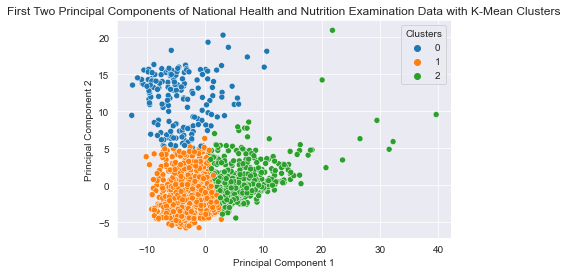

In [20]:
ax = sns.scatterplot(x = pc_df[0], y = pc_df[1], hue = pc_df["Clusters"], palette = "tab10")
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 2")
ax.set_title("First Two Principal Components of National Health and Nutrition Examination Data with K-Mean Clusters")
plt.show()

When we retrain the clustering algorithm using our results from the principal compenent analysis we start to see a clearer pattern emerge. The clusters plot neatly over principal components 1 and 2, which make us wonder about the features included in each principal component and how they are related--as bundled components--to the clustered data.  


## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Based on Aniket's code, we create a function for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

In [21]:
import keras
def NN_tune (X,y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10) 
    
    num_classes = len(y.unique()) # binarized 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train,num_classes)
    y_test = keras.utils.to_categorical(y_test,num_classes)
    num_classes = y_train.shape[1]
    xshape = X_train.shape[1] 
    
    NN_model = Sequential()


    NN_model.add(
        Dense(xshape, input_dim = xshape, kernel_initializer= 'normal', activation= 'relu')
    )

    NN_model.add(
        Dense(num_classes, input_dim= num_classes, kernel_initializer= 'normal', activation= 'softmax') 
    )

    NN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    NN_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

    NN_scores = NN_model.evaluate(X_test, y_test, verbose=0)
    results = print("Neural Network Error: %.2f%%" % (100-NN_scores[1]*100))
    
    return(results)

### Neural Network on Original Features

In [22]:
y = hsd010_binary.replace(["good", "poor"],
                          [1,0])  # numeric binary 

X = nhanes_scaled # scaled DF already dropped targets 

NN_tune(X,y)


Epoch 1/10
8/8 - 0s - loss: 0.4825 - accuracy: 0.7894 - val_loss: 0.3761 - val_accuracy: 0.8527
Epoch 2/10
8/8 - 0s - loss: 0.3374 - accuracy: 0.8669 - val_loss: 0.3675 - val_accuracy: 0.8624
Epoch 3/10
8/8 - 0s - loss: 0.3007 - accuracy: 0.8805 - val_loss: 0.3546 - val_accuracy: 0.8702
Epoch 4/10
8/8 - 0s - loss: 0.2669 - accuracy: 0.8960 - val_loss: 0.3474 - val_accuracy: 0.8605
Epoch 5/10
8/8 - 0s - loss: 0.2384 - accuracy: 0.9070 - val_loss: 0.3414 - val_accuracy: 0.8682
Epoch 6/10
8/8 - 0s - loss: 0.2149 - accuracy: 0.9186 - val_loss: 0.3395 - val_accuracy: 0.8643
Epoch 7/10
8/8 - 0s - loss: 0.1960 - accuracy: 0.9251 - val_loss: 0.3390 - val_accuracy: 0.8682
Epoch 8/10
8/8 - 0s - loss: 0.1761 - accuracy: 0.9322 - val_loss: 0.3416 - val_accuracy: 0.8682
Epoch 9/10
8/8 - 0s - loss: 0.1574 - accuracy: 0.9457 - val_loss: 0.3491 - val_accuracy: 0.8663
Epoch 10/10
8/8 - 0s - loss: 0.1408 - accuracy: 0.9548 - val_loss: 0.3541 - val_accuracy: 0.8643
Neural Network Error: 13.57%


### Neural Network on Principal Components

In [23]:
y = hsd010_binary.replace(["good", "poor"],
                          [1,0])  # numeric binary 

X = pc_df.drop('Clusters',axis=1) # scaled df of PCA components, but drop cluster membership before doing so 

NN_tune(X,y)

Epoch 1/10
8/8 - 0s - loss: 0.6398 - accuracy: 0.6634 - val_loss: 0.5350 - val_accuracy: 0.8508
Epoch 2/10
8/8 - 0s - loss: 0.4777 - accuracy: 0.8391 - val_loss: 0.4353 - val_accuracy: 0.8508
Epoch 3/10
8/8 - 0s - loss: 0.3973 - accuracy: 0.8424 - val_loss: 0.3885 - val_accuracy: 0.8508
Epoch 4/10
8/8 - 0s - loss: 0.3474 - accuracy: 0.8540 - val_loss: 0.3629 - val_accuracy: 0.8566
Epoch 5/10
8/8 - 0s - loss: 0.3122 - accuracy: 0.8695 - val_loss: 0.3463 - val_accuracy: 0.8605
Epoch 6/10
8/8 - 0s - loss: 0.2859 - accuracy: 0.8824 - val_loss: 0.3349 - val_accuracy: 0.8682
Epoch 7/10
8/8 - 0s - loss: 0.2653 - accuracy: 0.8947 - val_loss: 0.3289 - val_accuracy: 0.8663
Epoch 8/10
8/8 - 0s - loss: 0.2484 - accuracy: 0.9037 - val_loss: 0.3256 - val_accuracy: 0.8643
Epoch 9/10
8/8 - 0s - loss: 0.2341 - accuracy: 0.9096 - val_loss: 0.3251 - val_accuracy: 0.8643
Epoch 10/10
8/8 - 0s - loss: 0.2212 - accuracy: 0.9115 - val_loss: 0.3249 - val_accuracy: 0.8663
Neural Network Error: 13.37%


### Neural Network on Principal Components + Cluster Membership

In [24]:
y = hsd010_binary.replace(["good", "poor"],
                          [1,0])  # numeric binary 

X = pc_df # scaled df of PCA components and cluster membership

NN_tune(X,y)

Epoch 1/10
8/8 - 0s - loss: 0.5828 - accuracy: 0.7771 - val_loss: 0.4753 - val_accuracy: 0.8547
Epoch 2/10
8/8 - 0s - loss: 0.4502 - accuracy: 0.8359 - val_loss: 0.4035 - val_accuracy: 0.8527
Epoch 3/10
8/8 - 0s - loss: 0.3824 - accuracy: 0.8424 - val_loss: 0.3688 - val_accuracy: 0.8508
Epoch 4/10
8/8 - 0s - loss: 0.3370 - accuracy: 0.8643 - val_loss: 0.3476 - val_accuracy: 0.8566
Epoch 5/10
8/8 - 0s - loss: 0.3034 - accuracy: 0.8792 - val_loss: 0.3335 - val_accuracy: 0.8624
Epoch 6/10
8/8 - 0s - loss: 0.2771 - accuracy: 0.8953 - val_loss: 0.3261 - val_accuracy: 0.8663
Epoch 7/10
8/8 - 0s - loss: 0.2579 - accuracy: 0.8999 - val_loss: 0.3209 - val_accuracy: 0.8702
Epoch 8/10
8/8 - 0s - loss: 0.2417 - accuracy: 0.9037 - val_loss: 0.3187 - val_accuracy: 0.8682
Epoch 9/10
8/8 - 0s - loss: 0.2276 - accuracy: 0.9102 - val_loss: 0.3186 - val_accuracy: 0.8702
Epoch 10/10
8/8 - 0s - loss: 0.2148 - accuracy: 0.9154 - val_loss: 0.3196 - val_accuracy: 0.8682
Neural Network Error: 13.18%


## Discussion Questions

**1. In your own words, what is the difference between PCA and clustering?**

In principal component analysis, we reduce our data by combining features, therefore reducing the dimensionality of the entire dataset. With clustering, the objective is to combine observations and describe a point relative to the cluster of data that it best fits. Ultimately, PCA helps us to reduce the features in the data while clustering is a method to help us discover meaningful groups in the data.  

**2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?**

Combining PCA and clustering proved to be useful for our analysis. We see this clearly when considering the BMI and Income to Poverty Line Ratio features. In the box plots included in our descriptive analysis, we can see a relationship emerge between the features (BMI and Income to Poverty Line Ratio) and the self-reported health condition of an individual. This might lead us to believe that when we cluster the data and re-run the plot that we might see a stronger pattern between the two features, yet with clustering alone, we really are not able to discern any meaningful patterns. However, using PCA as a first step—allowing us to reduce the dimensionality of the data by bundling several of the features—we see that the three clusters map quite cleanly onto the first two components.

**3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"**

Unsupervised learning techniques aid in discovering patterns, similarities and other “unknowns” in the data, which are critical pre-processing and exploratory analysis steps towards training supervised learning algorithms. Using PCA for dimensionality reduction makes it a powerful method for initially exploring data—we can see that this technique allows us to view how each feature loads onto various components, consider how to conceptualize the components, and then use the components for further analysis. We also see that clustering techniques would be well suited for exploring longitudinal and nested data sets. For example, in education-related research where students are nested in classrooms, within schools, which are nested in districts, this technique would be helpful for exploring within- and between-group variation to better inform a supervised learning task in a subsequent analysis. 